In [1]:
# After unzipping training data manually, all 25000 images are in the 'train' folder.
# Use the script below to put dog images into 'train/dogs/' and cat images into 'train/cats/'

import os
import numpy as np

dir_train = 'train'
dir_train_dogs = 'train/dogs'
dir_train_cats = 'train/cats'

dir_valid = 'valid'
dir_valid_dogs = 'valid/dogs'
dir_valid_cats = 'valid/cats'

if not os.path.exists(dir_train_dogs):
    os.mkdir(dir_train_dogs)
    
if not os.path.exists(dir_train_cats):
    os.mkdir(dir_train_cats)
    
if not os.path.exists(dir_valid_dogs):
    os.mkdir(dir_valid_dogs)
    
if not os.path.exists(dir_valid_cats):
    os.mkdir(dir_valid_cats)

# Initially all images are put in 'train'
# separate dogs and cats in train/dogs and train/cats
[os.rename(os.path.join(dir_train, f), os.path.join(dir_train_dogs, f)) for f in os.listdir(dir_train) if 'dog.' in f]
[os.rename(os.path.join(dir_train, f), os.path.join(dir_train_cats, f)) for f in os.listdir(dir_train) if 'cat.' in f]

# select 500 images for validation repectively
# [os.rename(os.path.join(dir_train_dogs, f), os.path.join(dir_valid_dogs, f)) for f in np.random.choice(os.listdir(dir_train_dogs), 500, replace=False)]
# [os.rename(os.path.join(dir_train_cats, f), os.path.join(dir_valid_cats, f)) for f in np.random.choice(os.listdir(dir_train_cats), 500, replace=False)]

print('There are ', len(os.listdir(dir_train_dogs)), 'dog train images')
print('There are ', len(os.listdir(dir_train_cats)), 'cat train images')
print('There are ', len(os.listdir(dir_valid_dogs)), 'dog valid images')
print('There are ', len(os.listdir(dir_valid_cats)), 'cat valid images')

There are  12000 dog train images
There are  12000 cat train images
There are  500 dog valid images
There are  500 cat valid images


In [2]:
# Declare the ImageDataGenerator of Keras

import keras
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    dir_train, 
    target_size=(224, 224), 
    batch_size=16, 
    class_mode='categorical', 
    shuffle=True) 


Using TensorFlow backend.


Found 24000 images belonging to 2 classes.


In [6]:
# Randomly load 2000 images for normalization
import numpy as np
import cv2

X_train = []
for f in np.random.choice(os.listdir(dir_train_dogs), 100, replace=False):
    X_train.append(cv2.resize(cv2.imread(os.path.join(dir_train_dogs, f)), (224, 224)))
for f in np.random.choice(os.listdir(dir_train_cats), 100, replace=False):
    X_train.append(cv2.resize(cv2.imread(os.path.join(dir_train_cats, f)), (224, 224)))

# X_train = np.stack(X_train).astype(float)

# train_datagen.fit() outputs strange mean and std ...
train_datagen.fit(X_train)

# manually calculate and set
# train_datagen.mean = np.mean(X_train, axis=(0,1,2))
# train_datagen.std = np.std(X_train, axis=(0,1,2))


print('normalization mean:', train_datagen.mean)
print('normalization std:', train_datagen.std)

del X_train

normalization mean: [[[105.348816 115.52777  124.6818  ]]]
normalization std: [[[64.44511  63.907593 64.665245]]]


In [7]:
# prepare validation data
X_valid = []
y_valid = []
for f in os.listdir(dir_valid_dogs):
    X_valid.append(cv2.resize(cv2.imread(os.path.join(dir_valid_dogs, f)), (224, 224)))
    y_valid.append(1)
for f in os.listdir(dir_valid_cats):
    X_valid.append(cv2.resize(cv2.imread(os.path.join(dir_valid_cats, f)), (224, 224)))
    y_valid.append(0)
    
X_valid = np.stack(X_valid).astype(float)
# X_valid = train_datagen.standardize(X_valid)
y_valid = keras.utils.to_categorical(y_valid, 2)


print('There are', X_valid.shape[0], 'validation data')
print('X_valid.shape =', X_valid.shape)
print('y_valid.shape =', y_valid.shape)

There are 1000 validation data
X_valid.shape = (1000, 224, 224, 3)
y_valid.shape = (1000, 2)


In [8]:
# import gc
# from keras import backend as K
# K.clear_session()
# gc.collect()

5

In [8]:
# load pre-trained cnn model: 
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Activation, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model

base_model = ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (224, 224, 3),
    pooling = 'None')

# Add a layer for two-class classification
last_layer = base_model.output
last_layer = BatchNormalization(axis=3)(last_layer)
last_layer = GlobalAveragePooling2D()(last_layer)
last_layer = Dense(2, activation='softmax')(last_layer)

# Do not train original parameters
for layer in base_model.layers:
    layer.trainable = False

model = Model(input=base_model.input, output=last_layer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

del base_model

print('model contains', len(model.layers), 'layers')

/home/cvbridgechiao/kaggle/dogs_vs_cats/venv/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


model contains 178 layers


/home/cvbridgechiao/kaggle/dogs_vs_cats/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [9]:
# training process

history = model.fit_generator(train_generator, epochs=10, steps_per_epoch=100, validation_data=(X_valid[:100], y_valid[:100]))

Epoch 1/10
100/100 [==============================] - 27s 268ms/step - loss: 0.1959 - acc: 0.9275 - val_loss: 0.1188 - val_acc: 0.9200
Epoch 2/10
100/100 [==============================] - 23s 233ms/step - loss: 0.1209 - acc: 0.9506 - val_loss: 0.1297 - val_acc: 0.9400
Epoch 3/10
100/100 [==============================] - 25s 250ms/step - loss: 0.1296 - acc: 0.9519 - val_loss: 0.0995 - val_acc: 0.9500
Epoch 4/10
100/100 [==============================] - 24s 240ms/step - loss: 0.1389 - acc: 0.9419 - val_loss: 0.0930 - val_acc: 0.9700
Epoch 5/10
100/100 [==============================] - 25s 245ms/step - loss: 0.1104 - acc: 0.9537 - val_loss: 0.1352 - val_acc: 0.9400
Epoch 6/10
100/100 [==============================] - 24s 241ms/step - loss: 0.1044 - acc: 0.9606 - val_loss: 0.1430 - val_acc: 0.9300
Epoch 7/10
100/100 [==============================] - 24s 237ms/step - loss: 0.1221 - acc: 0.9500 - val_loss: 0.1039 - val_acc: 0.9600
Epoch 8/10
100/100 [==============================] - 2

In [10]:
print(model.evaluate(X_valid, y_valid))

1000/1000 [==============================] - 10s 10ms/step
[0.07278421886730939, 0.972]


In [8]:
np.mean(X_valid)

114.95504348692602

In [35]:
for i in range(10):
    (dx, dy) = train_generator.next()    
    print(model.evaluate(dx* train_datagen.std + train_datagen.mean, dy))


16/16 [==============================] - 0s 12ms/step
[0.0028864704072475433, 1.0]
16/16 [==============================] - 0s 11ms/step
[0.4405885338783264, 0.875]
16/16 [==============================] - 0s 10ms/step
[0.03414473682641983, 1.0]
16/16 [==============================] - 0s 9ms/step
[0.004915534518659115, 1.0]
16/16 [==============================] - 0s 9ms/step
[0.306986927986145, 0.875]
16/16 [==============================] - 0s 9ms/step
[0.32167842984199524, 0.9375]
16/16 [==============================] - 0s 9ms/step
[0.43818944692611694, 0.875]
16/16 [==============================] - 0s 9ms/step
[0.007201753091067076, 1.0]
16/16 [==============================] - 0s 9ms/step
[0.10804307460784912, 0.9375]
16/16 [==============================] - 0s 9ms/step
[0.00823183823376894, 1.0]


In [43]:
# vx = train_datagen.standardize(X_valid[100:150])
vx = X_valid[100:150]
print(np.mean(vx))
vy = y_valid[100:150]
print(model.evaluate(vx, vy))

0.12911976972411596
50/50 [==============================] - 1s 10ms/step
[2.1362259674072264, 0.04]


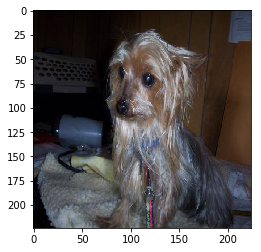

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow((x[5] * train_datagen.std + train_datagen.mean).astype(int))

In [ ]:
model.save('my_model.h5')